In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
import cv2
import os
from PIL import Image
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset
from tqdm import tqdm
import torch
from torch import optim
from torch.autograd import Variable
from torch.utils.data import random_split, DataLoader
from torch import nn
import torch.nn.functional as F
from torchvision.utils import make_grid
from torchvision import transforms, models, datasets

In [2]:
## load data

#train data and test data path
train_data_base_path = "/content/drive/MyDrive/training"
test_data_base_path = "/content/drive/MyDrive/testing"

#Normalize with mean[0.485, 0.456, 0.406] and std[0.229, 0.224, 0.225]
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

#data transforms
train_transforms = transforms.Compose([transforms.Resize((150, 150)), # Resize all images 
                    transforms.RandomResizedCrop(150),# Crop
                    transforms.RandomRotation(30), # Rotate 
                    transforms.RandomHorizontalFlip(), # Flip
                    transforms.ToTensor(), # Convert
                    normalize # Normalize
                                       ])
test_transforms = transforms.Compose([transforms.ToPILImage(),
                    transforms.Resize((150, 150)),
                    transforms.CenterCrop(150),
                    transforms.ToTensor(),
                    normalize
                                     ])

tmp_data = datasets.ImageFolder(train_data_base_path, transform=train_transforms)
# len(tmp_data): 1500

#data split
train_data, val_data = random_split(tmp_data,[1200,300] ,generator=torch.Generator().manual_seed(42))

train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=128)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


('Labels', tensor([ 2,  0,  3, 13,  4,  2,  8, 11,  7, 10,  5,  3, 11,  9,  4,  9,  6,  7,
        10,  5, 13,  6,  2,  2,  6,  6,  0,  7, 14,  0,  0,  0,  7, 11, 11, 14,
        11,  8,  8, 14, 10,  4, 14,  3, 13, 11,  0,  4,  3,  4,  2,  8, 12,  3,
         3, 14,  7,  3,  9,  4, 13, 10,  9, 13,  4, 12,  1,  5, 11,  0,  9,  9,
        13, 13,  2,  2, 11, 11,  0,  1,  9,  6, 11, 14,  7, 11,  4, 11,  5, 14,
         9,  0,  5,  6,  7, 10, 13, 12, 11,  0, 13,  1, 12, 11,  6,  3,  9,  1,
         6,  4,  6,  1, 12, 14, 12,  9,  6,  2, 13, 13,  5,  3, 10,  0, 12,  9,
         5,  4]))


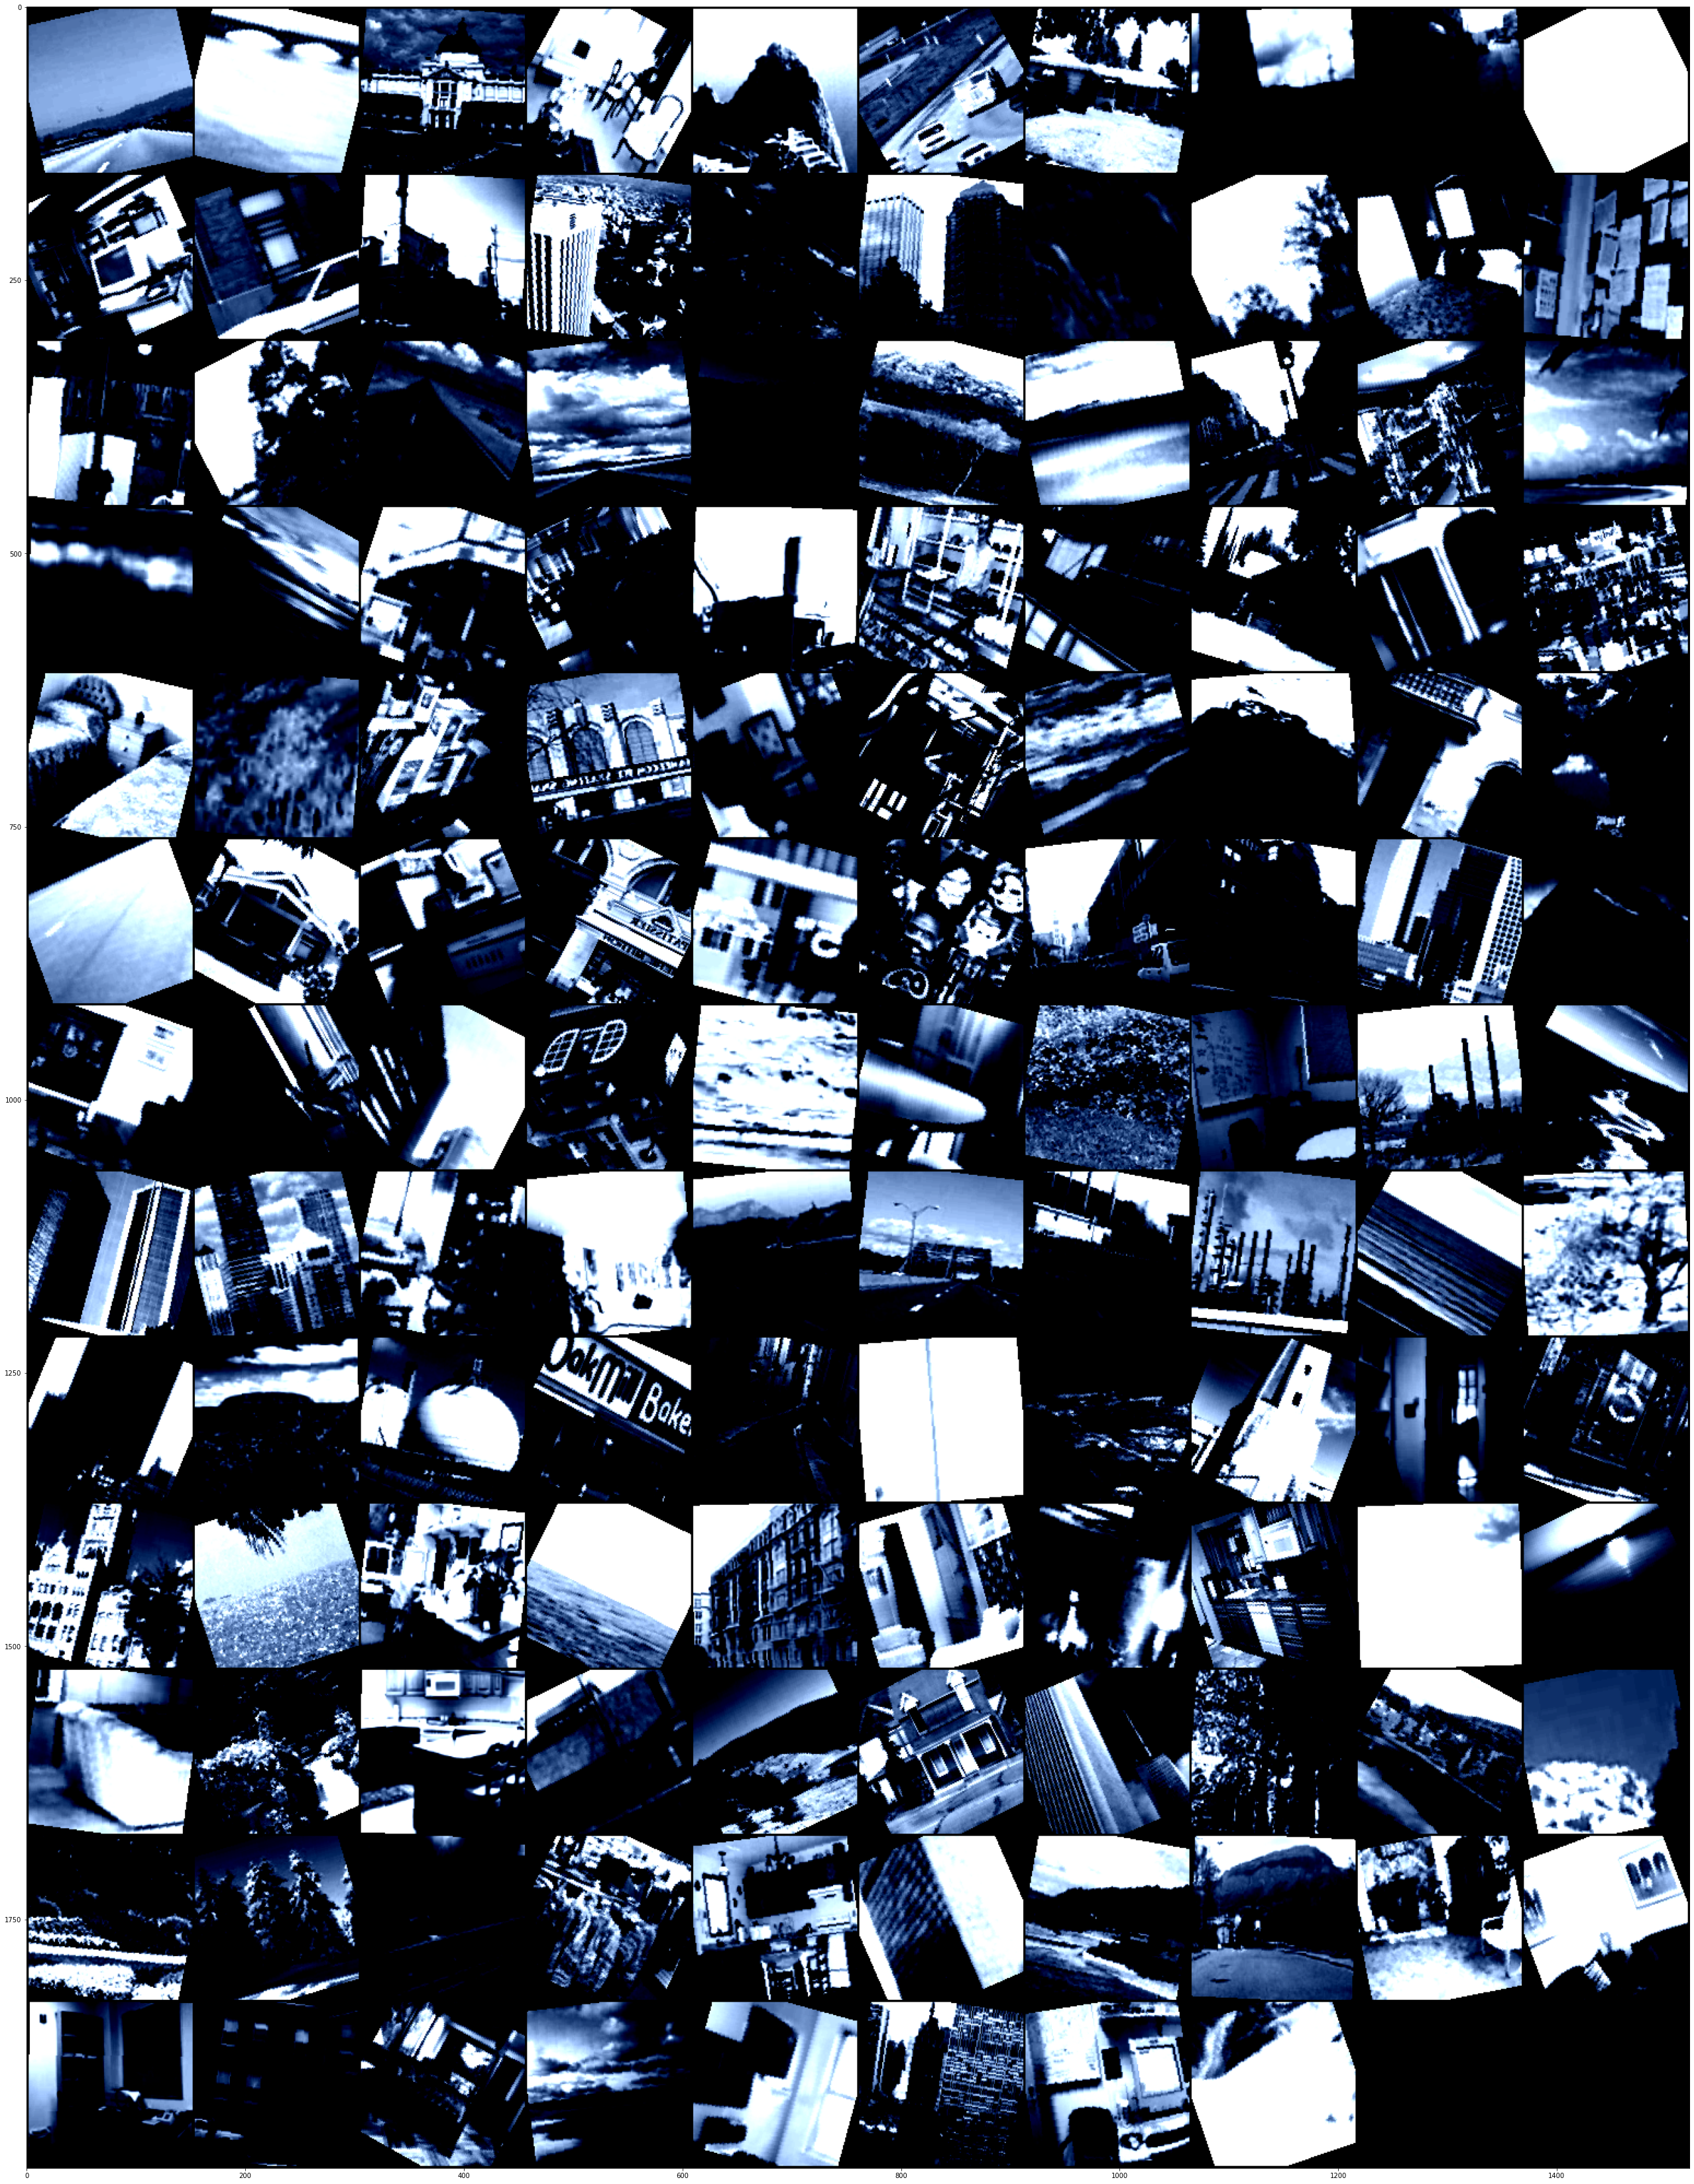

In [3]:
# Plot transformed images 
def show_transformed(loader):
    plt.figure(figsize=(60,60))
    # Interate single batch (64)
    batch = next(iter(loader))
    # for images, labels in single batch:
    images, labels = batch
    # torchvision make_grid
    grid = make_grid(images, nrow = 10)
    print(('Labels', labels))
    plt.imshow(np.transpose(grid, (1 ,2, 0)))
    plt.show()

show_transformed(train_loader)

In [4]:
#use GPU
device =  torch.device('cuda' if torch.cuda.is_available else 'cpu')
# Import resnet50
resnet = models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [5]:
# feature extract
feature_extractor_model = nn.Sequential(*list(resnet.children())[:-2], nn.AdaptiveAvgPool2d((1,1)))
feature_extractor_model.eval()
feature_extractor_model = feature_extractor_model.to(device)

training_features = []
training_labels = []
for imgs, labels in tqdm(train_loader):
    features = feature_extractor_model(imgs.to(device))
    for i in range(features.shape[0]):
        training_features.append(features[i].reshape(-1).cpu().detach().numpy())
        training_labels.append(labels[i])

training_features = np.array(training_features)
training_labels = np.array(training_labels)
np.save("/content/drive/MyDrive/training_features.npy", training_features)
np.save("/content/drive/MyDrive/training_labels.npy", training_labels)

valid_features = []
valid_labels = []
for imgs, labels in tqdm(val_loader):
    features = feature_extractor_model(imgs.to(device))
    for i in range(features.shape[0]):
        valid_features.append(features[i].reshape(-1).cpu().detach().numpy())
        valid_labels.append(labels[i])
valid_features = np.array(valid_features)
valid_labels = np.array(valid_labels)
np.save("/content/drive/MyDrive/valid_features.npy", valid_features)
np.save("/content/drive/MyDrive/valid_labels.npy", valid_labels)

100%|██████████| 3/3 [03:44<00:00, 74.71s/it]


In [9]:
# fun_tuning

# Freeze model params 
for param in resnet.parameters():
    param.required_grad = False

resnet.fc.weight.requires_grad = True #unfreeze last layer weights
resnet.fc.bias.requires_grad = True #unfreeze last layer biases
resnet.avgpool = nn.AdaptiveAvgPool2d((1,1))
resnet.fc = nn.Linear(2048, 15)

# # Pull final fc layer feature dimensions
# features = resnet.fc.in_features


# # Build custom classifier which reduces Resnets 1000 out_features to 6
# classifier = nn.Sequential(OrderedDict([('fc1', nn.Linear(features, 512)),
#                               ('relu', nn.ReLU()),
#                               ('drop', nn.Dropout(0.05)),
#                               ('fc2', nn.Linear(512, 15)),
#                                            ]))
# # Appending classifier layer to Resnet
# resnet.classifier = classifier
# Pushing the model to cuda
resnet.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [6]:
criterion = nn.CrossEntropyLoss()
optimiser = torch.optim.SGD(resnet.parameters(), lr=0.005)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimiser, milestones=[500,1000,1500,2000,2500], gamma=0.1)


In [7]:
epochs = 3000


tr_losses = []
avg_epoch_tr_loss = []
tr_accuracy = []


val_losses = []
avg_epoch_val_loss = []
val_accuracy = []
val_loss_min = np.Inf

In [10]:
resnet.train()
for epoch in tqdm(range(epochs)):
  for i, train in enumerate(train_loader):
    data, label = train

    data, label = data.to(device), label.to(device)

    optimiser.zero_grad()

    y_hat = resnet(data)

    loss = criterion(y_hat, label)

    loss.backward()

    optimiser.step()

    tr_losses.append(loss.item())

    tr_accuracy.append(label.eq(y_hat.argmax(dim=1)).float().mean())

  avg_epoch_tr_loss.append(torch.tensor(tr_losses).mean())
  resnet.eval()
  for i, batch in enumerate(val_loader):

    data, label = batch

    
    data, label = data.to(device), label.to(device)

    with torch.no_grad():
      y_hat = resnet(data)

    loss = criterion(y_hat, label)

    val_losses.append(loss.item())

    val_accuracy.append(label.eq(y_hat.argmax(dim=1)).float().mean())
    
  avg_epoch_val_loss.append(torch.tensor(val_losses).mean())

  # Checpoininting the model using val loss threshold
  if torch.tensor(val_losses).float().mean() <= val_loss_min:
    #print("Val Loss Decreased... Saving model")
    # save current model
    torch.save(resnet.state_dict(), './model_state.pt')
    val_loss_min = torch.tensor(val_losses).mean()
  # Step the scheduler for the next epoch
  scheduler.step()
  

  0%|          | 0/30 [01:54<?, ?it/s]


KeyboardInterrupt: ignored

3000


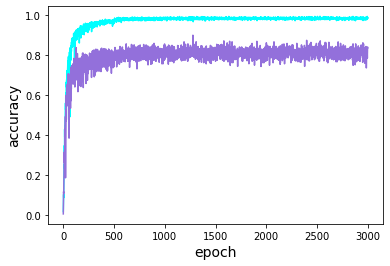

In [11]:

# plot accuracy
plt.xlabel('epoch',fontsize=14)

# train_accuracy = [sum(x) / float(len(x))
#  for x in (tr_accuracy[k : k + 10]
#            for k in range(0, len(tr_accuracy), 10))]
# vaild_accuracy = [sum(x) / float(len(x))
#  for x in (val_accuracy[k : k + 3]
#            for k in range(0, len(val_accuracy), 3))]
print(len(train_accuracy))
plt.ylabel('accuracy',fontsize=14)
plt.plot(torch.tensor(train_accuracy).cpu().numpy(),'-',c='cyan',label='train')  
plt.plot(torch.tensor(vaild_accuracy).cpu().numpy(),'-',c='mediumpurple',label='vaild')  
plt.savefig("/content/drive/MyDrive/accuracy_transfer.png")
plt.show()

In [15]:

#resnet = torch.load('/content/drive/MyDrive/resnet.pkl')
resnet.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# save run.txt
import gc

from glob import glob
from sklearn.preprocessing import LabelEncoder
test = []
filename = []
#f = glob(os.path.join(test_data_base_path, '*.jpg'))
img_path_list  = os.listdir(test_data_base_path)
img_path_list.sort(key=lambda x: int(x[:-4]))
for file in tqdm(img_path_list):
  image = cv2.imread(test_data_base_path+'/'+file)
  filename.append(file)
  #test.append(torch.as_tensor(np.resize(np.array(image).astype(float),(1,227,227))))
  test.append(image)
test_data = np.zeros((len(test),3,150,150))
for i in range(len(test)):
  test_data[i,:,:,:] = test_transforms(test[i])
# # get the inputs
# test_data = np.zeros((len(test),1,227,227))
# for i in range(len(test)):
#   test_data[i,:,:,:] = test[i]

categorys = os.listdir(train_data_base_path)
if categorys.__contains__('.DS_Store'):
    categorys.remove('.DS_Store')
le = LabelEncoder()
le.fit(categorys)
m = nn.Softmax(dim=1)
res=[]
for i in tqdm(range(30)):
  flag = (i+1)*100
  if i ==30:
    flag = len(test)
  inputs= torch.as_tensor(test_data[i*100:flag]).to(device)
  outputs = model(inputs.float())
  outputs = m(outputs)
  for j in range(len(outputs)):
    res.append(outputs[j].argmax().item())
  del inputs,outputs
  gc.collect()
res = le.inverse_transform(res)  
with open('./run3.txt', 'w') as file:
  for i in range(len(test)):
    file.write(str(filename[i].replace(test_data_base_path+'/', '') + ' ' + res[i] + '\n'))
  file.close()